In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from cluster_local import ClusterLensing_fyp
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

In [2]:
# inject data

scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)

# Example: Access the first datax array
print(f"Length of the first datax array: {len(datax_list[1])}")

Length of the first datax array: 678


In [3]:
# getting the pixel scale list
def get_pixscale(cluster_name, file_path='GCdata/pixsize'):
    full_path = os.path.join(file_dir, file_path)
    with open(full_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(cluster_name):
                # Split the line to get the value after the colon and return it as a float
                return float(line.split(':')[1].strip())
    return None  # Return None if the cluster name isn't found

pixscale_list = []
for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]
    pixscale = get_pixscale(full_cluster_name)
    pixscale_list.append(pixscale)
print(pixscale_list)

[0.2, 0.25, 0.25, 0.2, 0.2, 0.2]


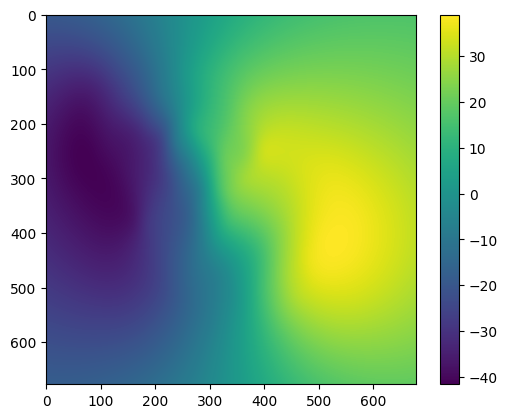

In [4]:
plt.imshow(datax_list[1], cmap='viridis')
plt.colorbar()

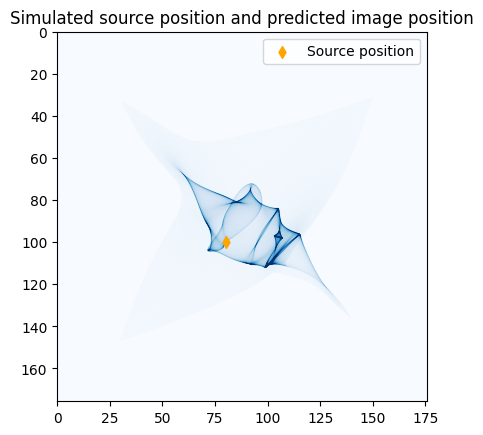

In [23]:
# look at the caustic
index = 4


size = len(datax_list[index])

array_test = np.zeros((size,size))
pixscale = pixscale_list[index]
datay = datay_list[index]/pixscale
datax = datax_list[index]/pixscale
# scal factor for real deflection map
scal = 1
datay *= scal *0.6855580650130826
datax *= scal *0.6855580650130826
for i in range(0,size):
    for j in range(0,size):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor,xfloor] += 1

plt.imshow(array_test, cmap='Blues', vmax = 50, extent=[0, size*pixscale, pixscale*size,0 ])
plt.scatter(80.1,99.9, c = 'orange', marker='d')
# plt.scatter([25.04527574, 80.3895084 , 89.83823507, 70.3500693 , 62.87531747,
#        63.56479705, 78.41485862],[96.30394225, 51.47812429, 71.45908221, 59.92729871, 45.81923451,
#        52.27263524, 72.34180586], c = 'r', marker='x')
# plt.xlim(85,110)
# plt.ylim(90,115)

plt.title('Simulated source position and predicted image position')
plt.legend(['Source position','Image position'])

# plt.savefig('Report images/src and img.pdf')

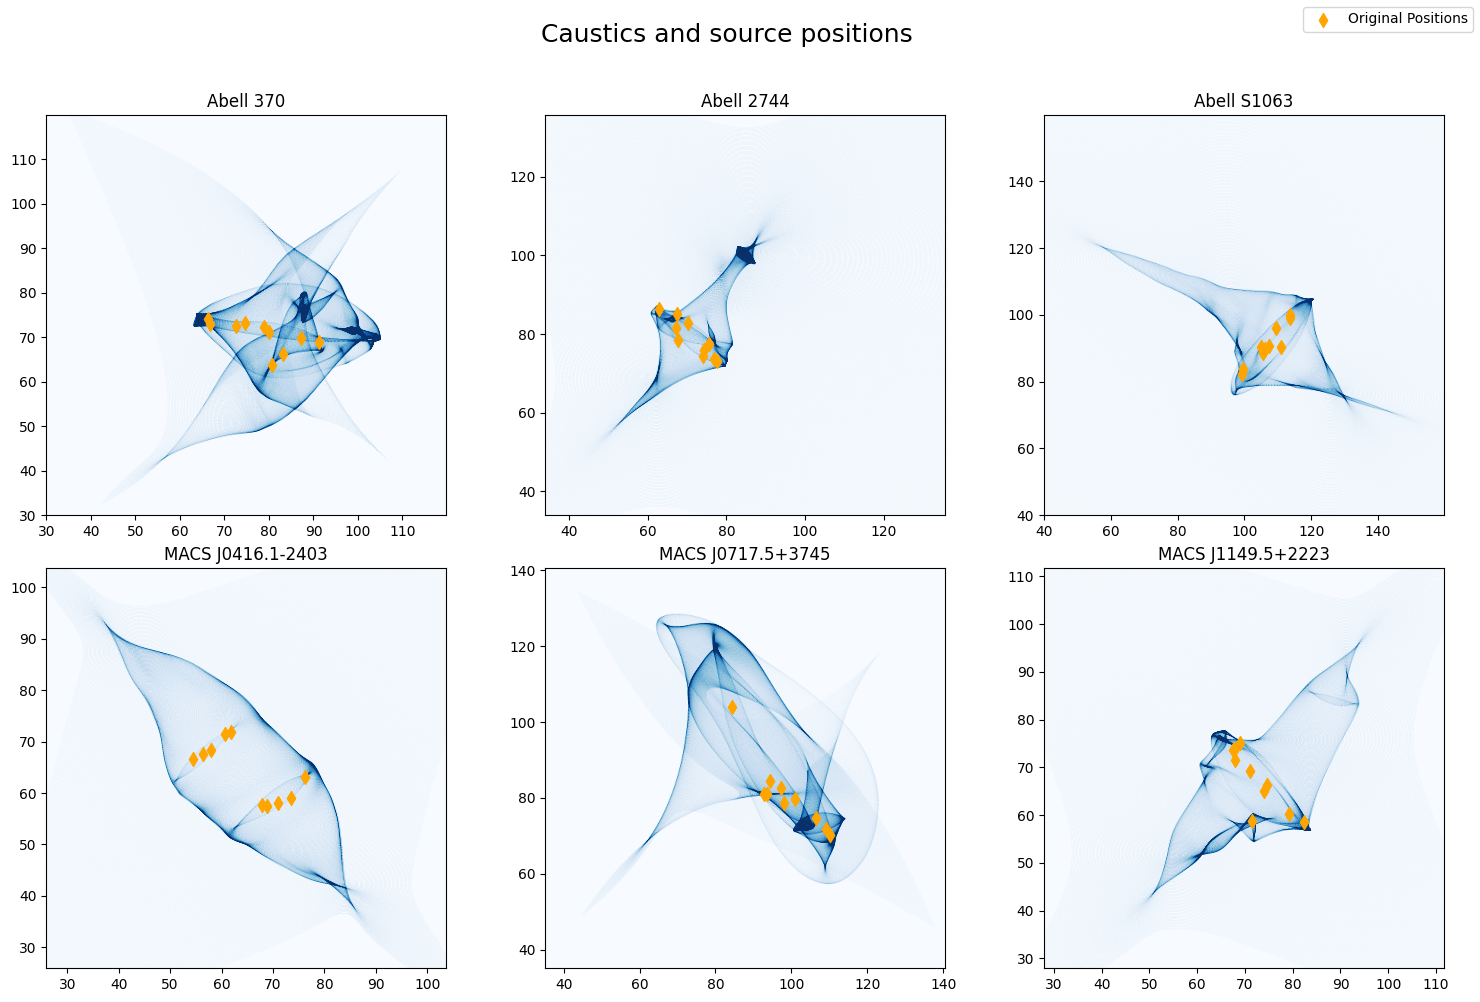

In [6]:
# make 6 graphs of the caustic
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Caustics and source positions', fontsize=18)
for i, ax in enumerate(axs.flat):
    size = len(datax_list[i])
    array_test = np.zeros((size, size))
    pixscale = pixscale_list[i]
    datay = datay_list[i] / pixscale
    datax = datax_list[i] / pixscale
    for j in range(0, size):
        for k in range(0, size):
            ycoord = j - datay[j, k]
            xcoord = k - datax[j, k]
            ydec = ycoord % 1
            xdec = xcoord % 1
            xfloor = floor(xcoord)
            yfloor = floor(ycoord)
            array_test[yfloor, xfloor] += 1
    ax.imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])
    ax.set_title(full_cluster_names[scenarios[str(i + 1)]])

    # Calculate new limits
    x_center = size * pixscale / 2
    y_center = size * pixscale / 2
    x_range = size * pixscale * 0.6
    y_range = size * pixscale * 0.6

    ax.set_xlim(x_center - x_range / 2, x_center + x_range / 2)
    ax.set_ylim(y_center + y_range / 2, y_center - y_range / 2)

    # Invert the y-axis
    ax.invert_yaxis()

    # Load the source positions from the CSV file
    src_pos_df = pd.read_csv('src_pos_for_distribution_2nd.csv')

    # Extract the (x, y) and (localized_x, localized_y) for the current cluster
    cluster_indices = src_pos_df[src_pos_df['indices'] == i]
    guess_indices = cluster_indices['localized_index'].values
    x = cluster_indices['x'].values
    y = cluster_indices['y'].values
    localized_x = cluster_indices['localized_x'].values
    localized_y = cluster_indices['localized_y'].values

    # Plot the extracted positions on the current cluster's caustic plot
    ax.scatter(x, y, c='orange', marker='d', label='Original Positions', s=50)
    #ax.scatter(localized_x, localized_y, c='m', marker='x', label='Localized Positions', s=40)
    

# Add a general legend for all the graphs
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.figtext(0.5, -0.06, 'Figure 2: Plots for stimulated and optimized source positions after localization for each cluster. All the orange and magenta labels of the source positions\nare overlapping each other except one, which indicates that the optimized result is very close to true source positions most of the time.', ha='center', fontsize=14)
plt.show()

fig.savefig('Report images/caustic and simulated src.pdf')

Text(0, 0.5, 'y (arcsec)')

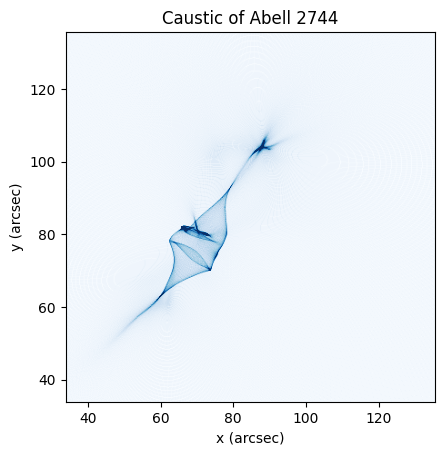

In [ ]:
size = len(datax_list[1])
array_test = np.zeros((size, size))
pixscale = pixscale_list[1]
datay = datay_list[1] / pixscale
datax = datax_list[1] / pixscale
for j in range(0, size):
    for k in range(0, size):
        ycoord = j - datay[j, k]
        xcoord = k - datax[j, k]
        ydec = ycoord % 1
        xdec = xcoord % 1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor, xfloor] += 1
plt.imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])
plt.title("Caustic of Abell 2744")

# Calculate new limits
x_center = size * pixscale / 2
y_center = size * pixscale / 2
x_range = size * pixscale * 0.6
y_range = size * pixscale * 0.6

plt.xlim(x_center - x_range / 2, x_center + x_range / 2)
plt.ylim(y_center + y_range / 2, y_center - y_range / 2)

# Invert the y-axis
plt.gca().invert_yaxis()

# Load the source positions from the CSV file
src_pos_df = pd.read_csv('src_pos_for_distribution_2nd.csv')

# Extract the (x, y) and (localized_x, localized_y) for the current cluster
cluster_indices = src_pos_df[src_pos_df['indices'] == 1]
guess_indices = cluster_indices['localized_index'].values
x = cluster_indices['x'].values
y = cluster_indices['y'].values
localized_x = cluster_indices['localized_x'].values
localized_y = cluster_indices['localized_y'].values

# Plot the extracted positions on the current cluster's caustic plot
#plt.scatter(x, y, c='orange', marker='d', label='Simulated Source', s=40)
#plt.legend()
plt.xlabel('x (arcsec)')
plt.ylabel('y (arcsec)')

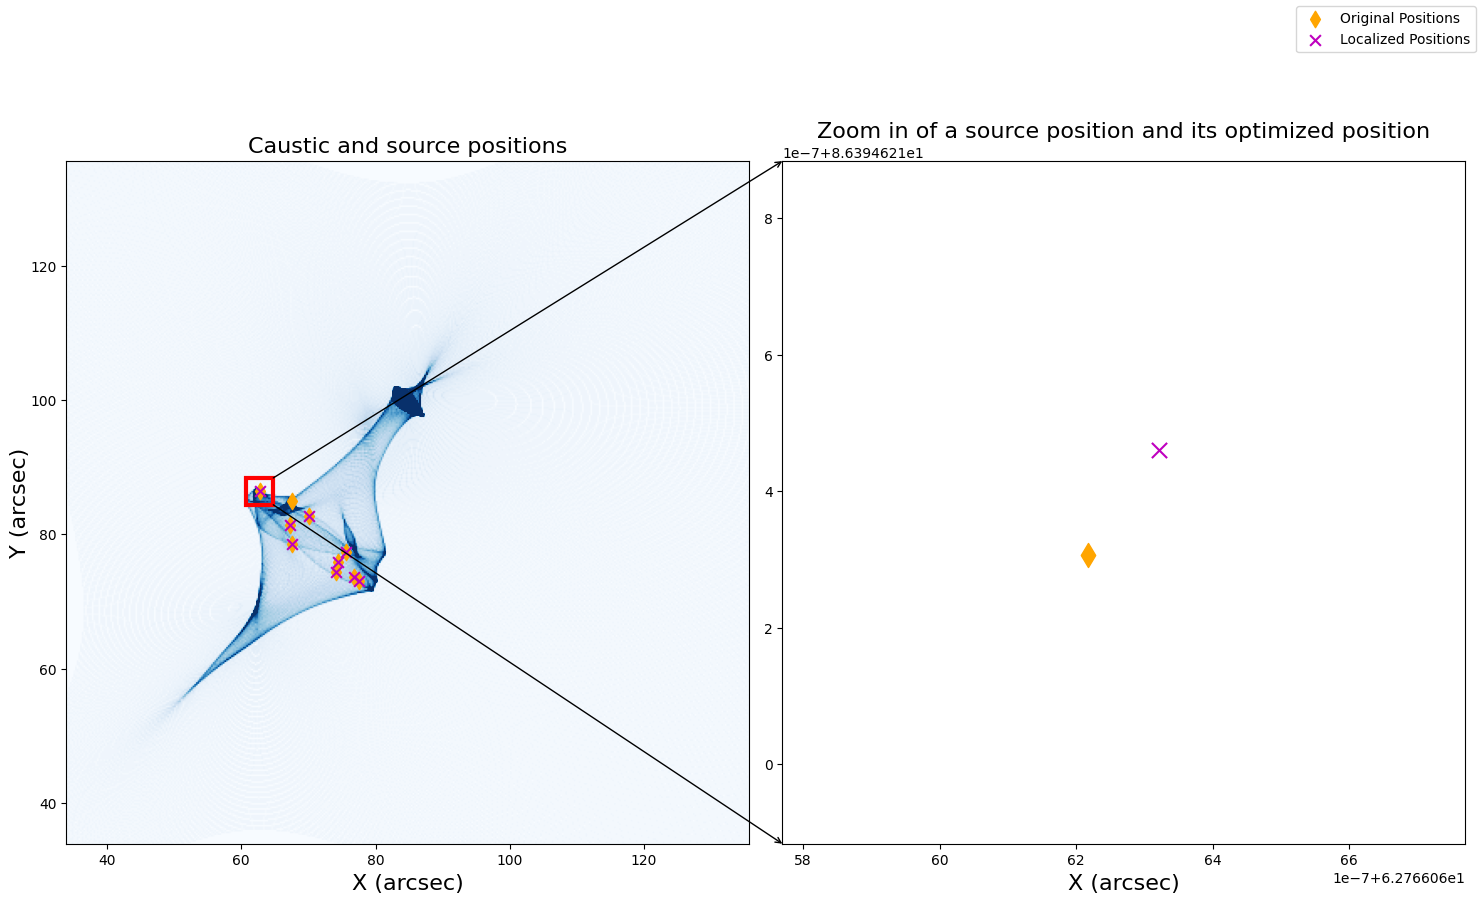

In [21]:
import matplotlib.patches as patches
# plot one source and its optimized source
fig, axes = plt.subplots(1,2, figsize=(15, 10))
description = ['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416.1-2403', 'MACS J0717.5+3745', 'MACS J1149.5+2223']

# Display the stimulated caustic on the right subplot
size = len(datax_list[1])
array_test = np.zeros((size, size))
pixscale = pixscale_list[1]
datay = datay_list[1] / pixscale
datax = datax_list[1] / pixscale
for j in range(0, size):
    for k in range(0, size):
        ycoord = j - datay[j, k]
        xcoord = k - datax[j, k]
        ydec = ycoord % 1
        xdec = xcoord % 1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor, xfloor] += 1
axes[0].imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])

# Calculate new limits
x_center = size * pixscale / 2
y_center = size * pixscale / 2
x_range = size * pixscale * 0.6
y_range = size * pixscale * 0.6

axes[0].set_xlim(x_center - x_range / 2, x_center + x_range / 2)
axes[0].set_ylim(y_center + y_range / 2, y_center - y_range / 2)

# Invert the y-axis
axes[0].invert_yaxis()

# Load the source positions from the CSV file
src_pos_df = pd.read_csv('src_pos_for_distribution_2nd.csv')

# Extract the (x, y) and (localized_x, localized_y) for the current cluster
cluster_indices = src_pos_df[src_pos_df['indices'] == 1]
guess_indices = cluster_indices['localized_index'].values
x = cluster_indices['x'].values
y = cluster_indices['y'].values

localized_x = cluster_indices['localized_x'].values
localized_y = cluster_indices['localized_y'].values
# Coordinates to remove
x_remove = 71.52470729854495
y_remove = 56.8670826021088

# Find the index where the (x, y) pair matches
remove_index = np.where((localized_x == x_remove) & (localized_y == y_remove))[0]

# Remove the values at that index
localized_x = np.delete(localized_x, remove_index)
localized_y = np.delete(localized_y, remove_index)
# Plot the extracted positions on the current cluster's caustic plot
axes[0].scatter(x, y, c='orange', marker='d', label='Original Positions', s=70)
axes[0].scatter(localized_x, localized_y, c='m', marker='x', label='Localized Positions', s=60)

size = 100
zoom_box_size = 4


# Draw a rectangle around the zoomed region
zoom_rect = patches.Rectangle((62.766066217725225-2,86.39462130682548-2),
                               zoom_box_size, zoom_box_size,
                               linewidth=3, edgecolor='red', facecolor='none', rotation_point="center")
axes[0].add_patch(zoom_rect)

# Add arrows connecting the zoom region to the right plot
for i, pos in enumerate([(62.766066217725225 + zoom_box_size / 2, 86.39462130682548 - zoom_box_size / 2),
                         (62.766066217725225 + zoom_box_size / 2, 86.39462130682548 + zoom_box_size / 2)]):
    con = patches.ConnectionPatch(xyA=pos, xyB=(0, 0) if i == 0 else (0, 1),
                                  coordsA="data", coordsB="axes fraction",
                                  axesA=axes[0], axesB=axes[1],
                                  color="black", arrowstyle="->")
    fig.add_artist(con)

axes[1].scatter(62.766066217725225,86.39462130682548, c='orange', marker='d', s=150)
axes[1].scatter(62.76606632104643,86.39462146020765, c='m', marker='x',  s=120)
x_cen = (62.766066217725225+62.76606632104643)/2
y_cen = (86.39462130682548+86.39462146020765)/2
axes[1].set_xlim(x_cen - 5e-7, x_cen + 5e-7)
axes[1].set_ylim(y_cen - 5e-7, y_cen + 5e-7)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_title('Zoom in of a source position and its optimized position', fontsize=16)
fig.legend()
fig.axes[0].set_title('Caustic and source positions', fontsize=16)
fig.supylabel('Y (arcsec)', fontsize=16)
axes[0].set_xlabel('X (arcsec)', fontsize=16)
axes[1].set_xlabel('X (arcsec)', fontsize=16)


# Adjust spacing
plt.tight_layout()
plt.show()

# save as pdf file
fig.savefig('Report images/zoom in src and optimized.pdf')

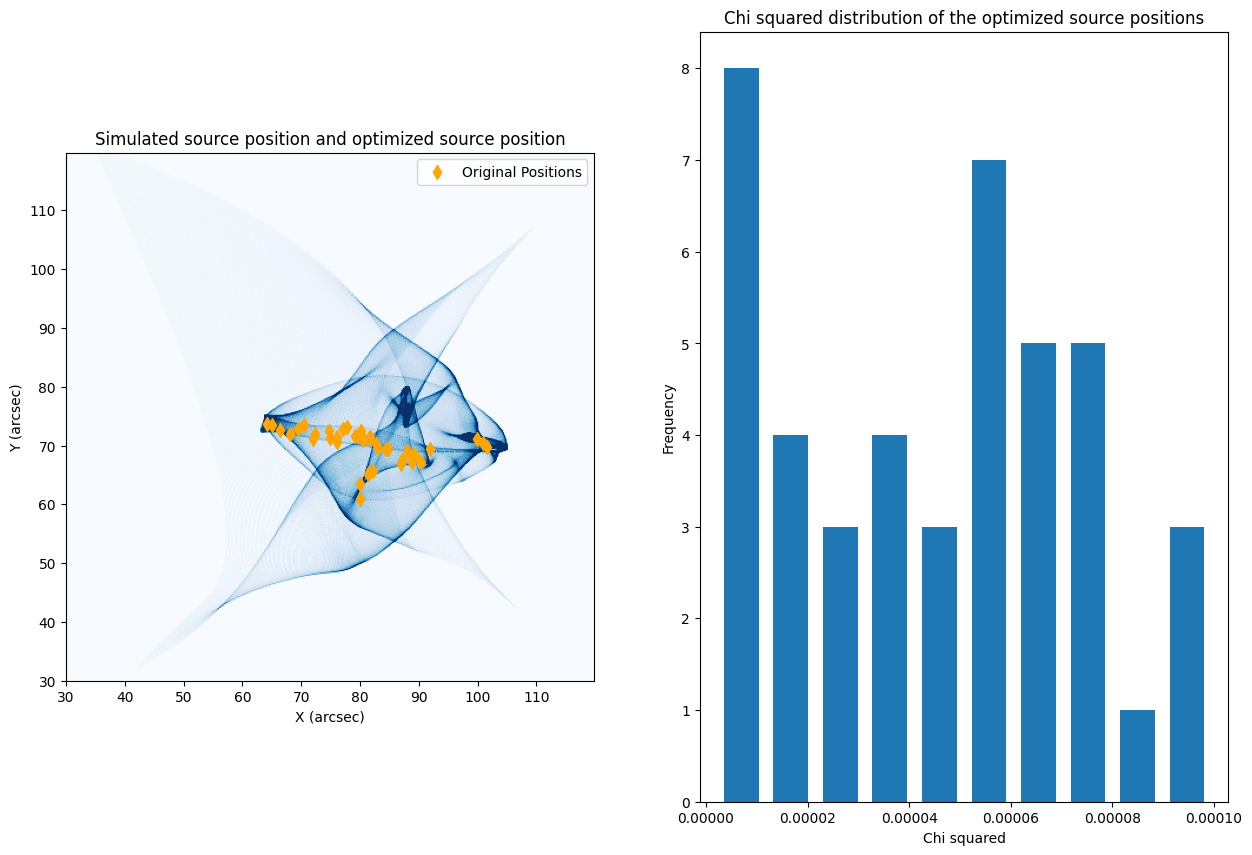

In [13]:
# plot one source and its optimized source
fig, axes = plt.subplots(1,2, figsize=(15, 10))
description = ['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416.1-2403', 'MACS J0717.5+3745', 'MACS J1149.5+2223']

# Display the stimulated caustic on the right subplot
size = len(datax_list[0])
array_test = np.zeros((size, size))
pixscale = pixscale_list[0]
datay = datay_list[0] / pixscale
datax = datax_list[0] / pixscale
for j in range(0, size):
    for k in range(0, size):
        ycoord = j - datay[j, k]
        xcoord = k - datax[j, k]
        ydec = ycoord % 1
        xdec = xcoord % 1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor, xfloor] += 1
axes[0].imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])
# Calculate new limits
x_center = size * pixscale / 2
y_center = size * pixscale / 2
x_range = size * pixscale * 0.6
y_range = size * pixscale * 0.6

axes[0].set_xlim(x_center - x_range / 2, x_center + x_range / 2)
axes[0].set_ylim(y_center + y_range / 2, y_center - y_range / 2)



# Invert the y-axis
axes[0].invert_yaxis()
# Load the source positions from the CSV file
src_pos_df = pd.read_csv('simulated_sources.csv')

# Extract the (x, y) and (localized_x, localized_y) for the current cluster
cluster_indices = src_pos_df[src_pos_df['indices'] == 0]
x = cluster_indices['x'].values
y = cluster_indices['y'].values

localized_x = cluster_indices['localized_x'].values
localized_y = cluster_indices['localized_y'].values
chi_sq = cluster_indices['localized_chi_sq'].values
axes[0].scatter(x, y, c='orange', marker='d', label='Original Positions', s=50)
#axes[0].scatter(localized_x, localized_y, c='m', marker='x', label='Localized Positions', s=50)
axes[0].set_title('Simulated source position and optimized source position')
axes[0].legend()
axes[0].set_xlabel('X (arcsec)')
axes[0].set_ylabel('Y (arcsec)')

axes[1].hist(chi_sq, bins = 10,rwidth=0.7)
axes[1].set_title('Chi squared distribution of the optimized source positions')
axes[1].set_xlabel('Chi squared')
axes[1].set_ylabel('Frequency')

plt.show()
fig.savefig('Report images/known_cluster.pdf')

Text(0, 0.5, 'Frequency')

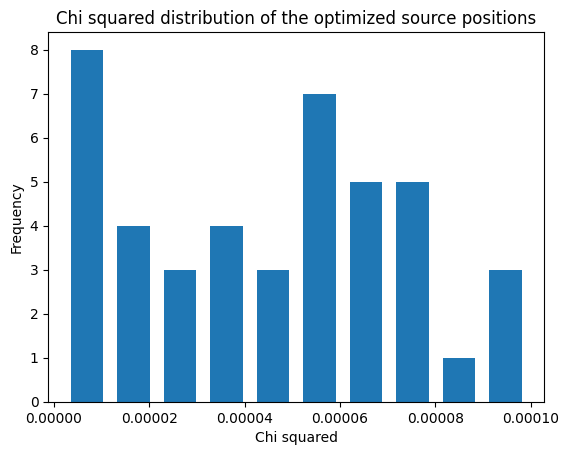

In [14]:
plt.hist(chi_sq, bins = 10,rwidth=0.7)
plt.title('Chi squared distribution of the optimized source positions')
plt.xlabel('Chi squared')
plt.ylabel('Frequency')

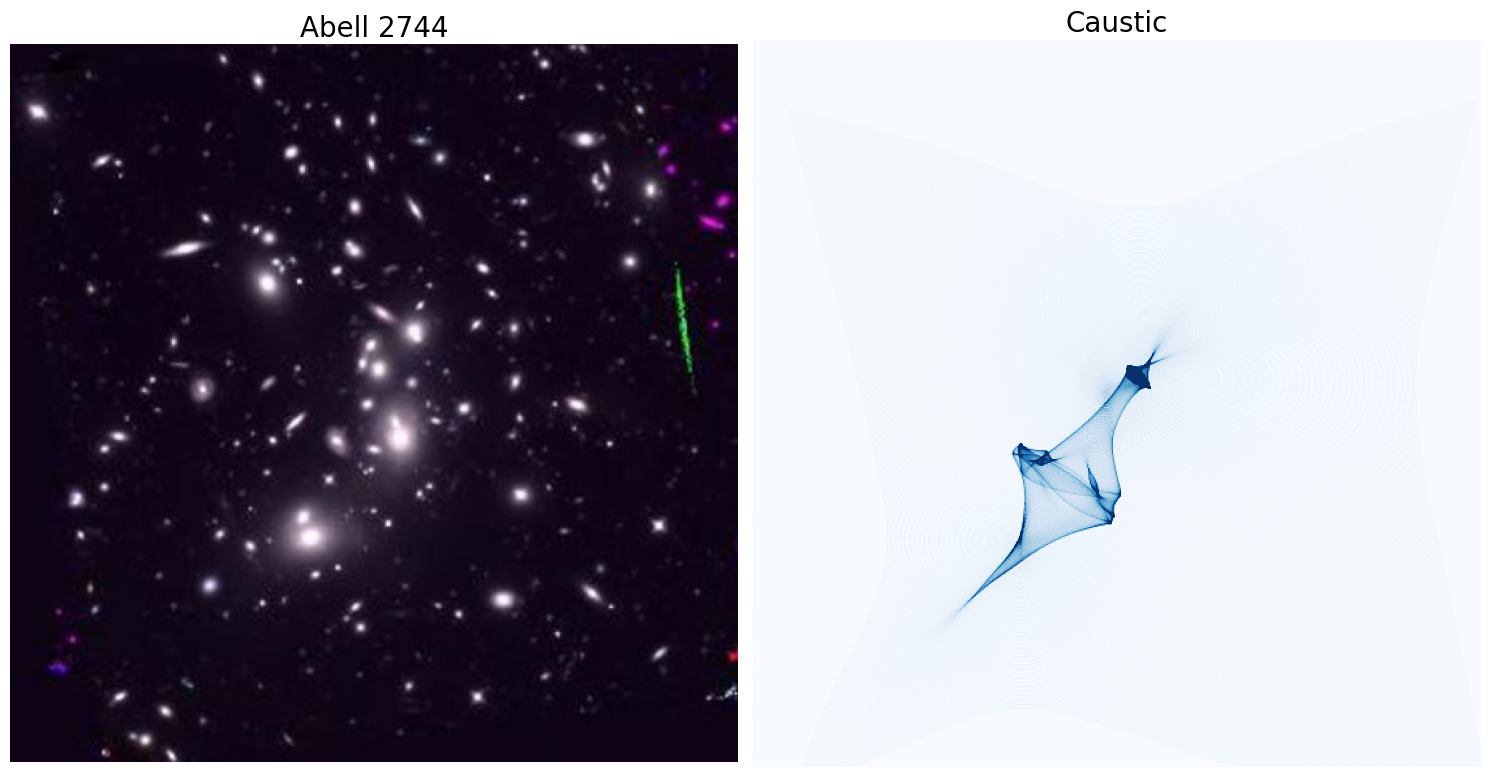

In [65]:
from PIL import Image

# List of image filenames
image_filenames = ['Report images/illustration 370.jpg','Report images/illustration 2744.JPG','Report images/illustartion s1063.tif', 
                   'Report images/illustration j0416.JPG', 'Report images/illustration j0717.JPG', 'Report images/illustration j1149.JPG']

# Number of rows and columns
rows = 1
cols = 2

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
description = ['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416.1-2403', 'MACS J0717.5+3745', 'MACS J1149.5+2223']

# only open the image of Abell 2744 at left and stimulated caustic at right
# Open the image of Abell 2744
image = Image.open(image_filenames[1])

# Display the image on the left subplot
axes[0].imshow(image)
axes[0].set_title(description[1], fontsize=20)
axes[0].axis('off')

# Display the stimulated caustic on the right subplot
axes[1].imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])
axes[1].set_xlim(11, 150.5)
axes[1].set_ylim(164.5, 25)
axes[1].invert_yaxis()
axes[1].set_title('Caustic', fontsize=20)
axes[1].axis('off')

# Adjust spacing
plt.tight_layout()
plt.show()
fig.savefig('Report images/illustration_v2.pdf')

In [60]:
# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.25
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale




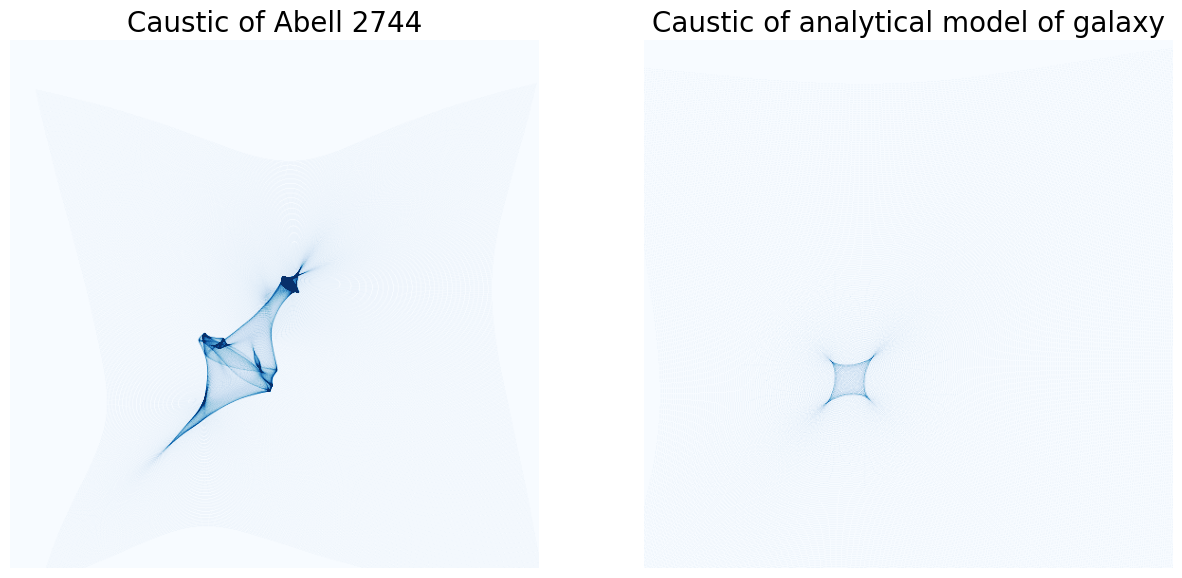

In [64]:
# illustrate the casutic
array_test1 = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%2==0 and j%2==0:
            array_test1[yfloor,xfloor] += 1 
      

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
description = ['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416.1-2403', 'MACS J0717.5+3745', 'MACS J1149.5+2223']

# only open the image of Abell 2744 at left and stimulated caustic at right
# Open the image of Abell 2744
image = Image.open(image_filenames[1])

# Display the image on the left subplot
axes[0].imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])
axes[0].set_xlim(11, 150.5)
axes[0].set_ylim(164.5, 25)
axes[0].invert_yaxis()
axes[0].set_title('Caustic of Abell 2744', fontsize=20)
axes[0].axis('off')

# Display the stimulated caustic on the right subplot
axes[1].imshow(array_test1, cmap='Blues', extent=[0, size * pixscale, pixscale * size, 0])
axes[1].set_xlim(21, 140.5)
axes[1].set_ylim(154.5, 35)
axes[1].invert_yaxis()
axes[1].set_title('Caustic of analytical model of galaxy', fontsize=20)
axes[1].axis('off')

fig.savefig('Report images/galaxy vs clusters.pdf')